# Basic Imports

In [1]:
from __future__ import print_function, division
import logging
reload(logging)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs).03d %(name)s %(message)s",
    datefmt='%Y-%m-%dT%H:%M:%S'
)

In [2]:
%matplotlib inline

import pandas
import numpy
from matplotlib import pylab
import seaborn

import ipywidgets as ipyw

import IPython
from IPython.display import display

In [3]:
import itertools
import toolz.dicttoolz
from toolz.dicttoolz import merge

In [4]:
!git show --oneline -s HEAD

be3dc53 Add replicate analysis workspace and analysis notebook.


In [5]:
import jug
jug.init("replicate_analysis.py")
import replicate_analysis

In [101]:
from replicate_analysis import replicate_pairs, parameter_sets, model_results, data
model_results = jug.value(model_results)

In [123]:
summary_frames = { d : {} for d in replicate_pairs }

for d, p in itertools.product(replicate_pairs, parameter_sets):
    sframes = []
    for mn in replicate_pairs[d]:
        counts = data.counts[mn]
        params = model_results[(mn, p)]["params"]
        preds = model_results[(mn, p)]["predictions"]
        
        sf = counts[["name"]].copy()
        sf["ec50"] = params["sel_ec50"]
        
        for g in preds:
            obs_dist = counts["counts%s" % g] / counts["counts%s" % g].sum()
            pred_dist = preds[g]["selection_dist"] / preds[g]["selection_dist"].sum()
            
            lobs_dist = numpy.log(obs_dist).clip(-9, None)
            lpred_dist = numpy.log(pred_dist).clip(-9, None)
            sf["l_dist_delta_%s" % g] = lobs_dist - lpred_dist
            sf["l_dist_delta_%s" % g][obs_dist == 0] = numpy.nan
            
        sframes.append(sf)
    
    summary_frames[d][p] = pandas.merge(*sframes, how="inner", on="name")

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [119]:
grocklin_fit_results = pandas.read_pickle("161115_grocklin_fit_results.pickle")

grockin_fit_frames = {
    d : pandas.merge(
        *[grocklin_fit_results[n][["name", "ec50"]] for n in p],
        how="inner", on="name"
    )
    for d, p in replicate_pairs.items()
}

In [120]:
import scipy.stats
from scipy.stats import pearsonr
import sklearn.metrics
from sklearn.metrics import mean_squared_error

In [121]:
model_param_evaluations = {
    "pearsonr" : lambda x1, x2: scipy.stats.pearsonr(x1, x2)[0],
    "neg_mse" : lambda x1, x2: -mean_squared_error(x1, x2),
    "neg_outlier_mse" : lambda x1, x2: (
        -numpy.mean(numpy.clip(numpy.abs(x1 - x2) - 1, 0, None) ** 2))
}

# Evaluation Overview

Adding evaluation via existing `model_param_evaluations` metrics, which measure concordance of replicate experiements.

Adding evaluation of model quality via sort-of-hacky mean-square-log-delta between observed and predicted population distributions. `ms_log_d` is a per-sort-round evaluation and `sum_ms_log_d` is a sum of per-sort-round evaluations.

In [165]:
eval_records = [
    merge(
        {
            "param_set" : param_set,
        },
        {
            e : ef(sf["ec50_x"], sf["ec50_y"])
            for e, ef in model_param_evaluations.items()
        },
        dict(param_set),
        dict(dataset=dataset),
        { 
            "fit_" + v : float(model_results[(dataset, param_set)]["params"].get(v, 0))
            for v in ("min_selection_mass", "min_selection_rate")
        },
        { "sel_k" : float(model_results[(dataset, param_set)]["params"]["sel_k"]) },
        {
            "ms_log_d_%s" % g : numpy.nanmean(numpy.square(sf["l_dist_delta_%s_x" % g]))
            for g in range(1, 7)
        },
    )
    for dataset in summary_frames
    for param_set, sf in summary_frames[dataset].items()
]

eval_records = pandas.DataFrame.from_records(eval_records)

eval_records["sum_ms_log_d"] = eval_records[["ms_log_d_%s" % i for i in range(1, 7)]].sum(axis=1)

In [166]:
grockin_eval_records = pandas.DataFrame.from_records([
    merge(
        {
            e : ef(sf["ec50_x"], sf["ec50_y"])
            for e, ef in model_param_evaluations.items()
        },
        dict(dataset=dataset),
    )
    for dataset, sf in grockin_fit_frames.items()
])

grockin_eval_records.sort_values("dataset")

,dataset,neg_mse,neg_outlier_mse,pearsonr
1,rd2_chymo,-1.761397,-0.686568,0.583877
2,rd2_tryp,-1.704013,-0.570927,0.453168
3,rd3_chymo,-0.347277,-0.068745,0.890660
0,rd3_tryp,-0.368697,-0.054830,0.892365


In [167]:
(
eval_records
.groupby(["dataset"])
.apply(lambda df: df.sort_values("neg_outlier_mse", ascending=False).head(1))
.sort_values("dataset")
)

,,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,sum_ms_log_d
dataset,,,,,,,,,,,,,,,,,,,
rd2_chymo,11,rd2_chymo,7.982873e-08,0.039959,True,True,0.083765,0.107915,0.019736,0.426496,0.338530,0.453415,-1.483345,-0.519545,"((min_selection_mass, True), (response_fn, Log...",0.539385,LogisticResponse,8.999035,1.429856
rd2_tryp,22,rd2_tryp,1.397716e-06,0.000000,True,False,0.031266,0.069643,0.063702,0.086612,0.031481,3.344543,-1.492558,-0.474356,"((min_selection_rate, False), (min_selection_m...",0.486105,LogisticResponse,8.998121,3.627246
rd3_chymo,24,rd3_chymo,1.339511e-11,0.013701,True,True,0.016125,0.021582,0.028420,0.191159,0.284324,0.932569,-0.272671,-0.038778,"((min_selection_mass, True), (min_selection_ra...",0.884062,NormalSpaceLogisticResponse,8.999152,1.474180
rd3_tryp,6,rd3_tryp,6.576743e-07,0.000000,True,False,0.011746,0.013247,0.046526,0.069069,0.055858,0.300154,-0.295254,-0.036448,"((min_selection_rate, False), (min_selection_m...",0.902604,LogisticResponse,8.999891,0.496601


In [168]:
import IPython

for g, df in eval_records.groupby("dataset"):
    IPython.display.display(g)
    IPython.display.display(df.sort_values("neg_outlier_mse", ascending=False))


'rd2_chymo'

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,sum_ms_log_d
11,rd2_chymo,7.982873e-08,0.039959,True,True,0.083765,0.107915,0.019736,0.426496,0.338530,0.453415,-1.483345,-0.519545,"((min_selection_mass, True), (response_fn, Log...",0.539385,LogisticResponse,8.999035,1.429856
12,rd2_chymo,0.000000e+00,0.039971,False,True,0.083715,0.107946,0.019745,0.427516,0.338617,0.453612,-1.561087,-0.565922,"((response_fn, LogisticResponse), (min_selecti...",0.529008,LogisticResponse,8.998927,1.431151
10,rd2_chymo,0.000000e+00,0.032091,False,True,0.091059,0.114383,0.023574,0.339174,0.395656,0.392226,-1.718884,-0.663354,"((response_fn, NormalSpaceLogisticResponse), (...",0.531770,NormalSpaceLogisticResponse,4.354829,1.356073
8,rd2_chymo,6.395431e-08,0.032107,True,True,0.090879,0.114373,0.023550,0.339665,0.396574,0.392809,-1.751856,-0.683431,"((min_selection_mass, True), (min_selection_ra...",0.527610,NormalSpaceLogisticResponse,4.357427,1.357851
13,rd2_chymo,6.275074e-07,0.000000,True,False,0.101428,0.132166,0.076982,0.431757,0.202272,0.370763,-1.973951,-0.694232,"((min_selection_rate, False), (min_selection_m...",0.614707,NormalSpaceLogisticResponse,0.576268,1.315368
14,rd2_chymo,3.735916e-07,0.000000,True,False,0.091338,0.135948,0.072650,0.540760,0.201750,0.314441,-2.246298,-0.906798,"((min_selection_rate, False), (min_selection_m...",0.569453,LogisticResponse,2.062127,1.356886
9,rd2_chymo,0.000000e+00,0.000000,False,False,0.091996,0.137606,0.075769,0.568929,0.197944,0.270007,-2.406670,-0.999630,"((min_selection_rate, False), (response_fn, Lo...",0.559962,LogisticResponse,1.996916,1.342251
15,rd2_chymo,0.000000e+00,0.000000,False,False,0.105071,0.141078,0.095675,0.548519,0.169674,0.322692,-2.971992,-1.335348,"((min_selection_rate, False), (response_fn, No...",0.522430,NormalSpaceLogisticResponse,0.451282,1.382709


'rd2_tryp'

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,sum_ms_log_d
22,rd2_tryp,1.397716e-06,0.000000,True,False,0.031266,0.069643,0.063702,0.086612,0.031481,3.344543,-1.492558,-0.474356,"((min_selection_rate, False), (min_selection_m...",0.486105,LogisticResponse,8.998121,3.627246
16,rd2_tryp,6.162128e-07,0.004396,True,True,0.031351,0.069367,0.063496,0.086985,0.013801,1.027367,-1.499369,-0.476906,"((min_selection_mass, True), (min_selection_ra...",0.477062,NormalSpaceLogisticResponse,8.998161,1.292366
19,rd2_tryp,5.850763e-07,0.004152,True,True,0.031512,0.071544,0.063539,0.088319,0.016040,1.003762,-1.619493,-0.551249,"((min_selection_mass, True), (response_fn, Log...",0.470627,LogisticResponse,8.998891,1.274716
18,rd2_tryp,0.000000e+00,0.004164,False,True,0.033008,0.082414,0.065947,0.091086,0.011329,0.593039,-1.887816,-0.673688,"((response_fn, NormalSpaceLogisticResponse), (...",0.408046,NormalSpaceLogisticResponse,8.998776,0.876821
21,rd2_tryp,1.602814e-06,0.000000,True,False,0.031281,0.068163,0.063070,0.085770,0.039883,3.204765,-2.065081,-0.762960,"((min_selection_rate, False), (min_selection_m...",0.415535,NormalSpaceLogisticResponse,8.990587,3.492932
20,rd2_tryp,0.000000e+00,0.004084,False,True,0.033043,0.082975,0.065972,0.091922,0.014359,0.588031,-2.029797,-0.763092,"((response_fn, LogisticResponse), (min_selecti...",0.403037,LogisticResponse,8.999345,0.876302
17,rd2_tryp,0.000000e+00,0.000000,False,False,0.036711,0.104047,0.070162,0.121810,0.096762,1.666586,-2.245994,-0.890327,"((min_selection_rate, False), (response_fn, Lo...",0.392534,LogisticResponse,5.425181,2.096078
23,rd2_tryp,0.000000e+00,0.000000,False,False,0.042059,0.116489,0.076177,0.136452,0.049319,2.679714,-2.285048,-0.913417,"((min_selection_rate, False), (response_fn, No...",0.379741,NormalSpaceLogisticResponse,3.811155,3.100210


'rd3_chymo'

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,sum_ms_log_d
24,rd3_chymo,1.339511e-11,0.013701,True,True,0.016125,0.021582,0.028420,0.191159,0.284324,0.932569,-0.272671,-0.038778,"((min_selection_mass, True), (min_selection_ra...",0.884062,NormalSpaceLogisticResponse,8.999152,1.474180
26,rd3_chymo,0.000000e+00,0.013518,False,True,0.016148,0.021755,0.028422,0.191252,0.269731,0.931313,-0.275241,-0.040040,"((response_fn, NormalSpaceLogisticResponse), (...",0.883208,NormalSpaceLogisticResponse,8.999150,1.458621
27,rd3_chymo,5.517879e-07,0.013045,True,True,0.016117,0.021731,0.028260,0.201006,0.248989,0.875767,-0.274765,-0.040268,"((min_selection_mass, True), (response_fn, Log...",0.888752,LogisticResponse,8.999453,1.391872
28,rd3_chymo,0.000000e+00,0.013206,False,True,0.016055,0.022064,0.028775,0.204540,0.237216,0.928415,-0.292129,-0.044424,"((response_fn, LogisticResponse), (min_selecti...",0.882044,LogisticResponse,8.999837,1.437066
30,rd3_chymo,1.113886e-06,0.000000,True,False,0.017686,0.026849,0.036364,0.386102,0.143940,2.443650,-0.312577,-0.051196,"((min_selection_rate, False), (min_selection_m...",0.891974,LogisticResponse,4.250204,3.054590
25,rd3_chymo,0.000000e+00,0.000000,False,False,0.018380,0.030358,0.038382,0.512054,0.119586,0.898877,-0.393576,-0.069282,"((min_selection_rate, False), (response_fn, Lo...",0.872244,LogisticResponse,3.720432,1.617637
29,rd3_chymo,2.647036e-06,0.000000,True,False,0.016232,0.021609,0.031535,0.235521,0.308963,2.956686,-0.631560,-0.078454,"((min_selection_rate, False), (min_selection_m...",0.877917,NormalSpaceLogisticResponse,8.991147,3.570545
31,rd3_chymo,0.000000e+00,0.000000,False,False,0.021704,0.034709,0.066881,0.566128,0.205586,2.020707,-0.708896,-0.113462,"((min_selection_rate, False), (response_fn, No...",0.869470,NormalSpaceLogisticResponse,1.575144,2.915715


'rd3_tryp'

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,sum_ms_log_d
6,rd3_tryp,6.576743e-07,0.000000,True,False,0.011746,0.013247,0.046526,0.069069,0.055858,0.300154,-0.295254,-0.036448,"((min_selection_rate, False), (min_selection_m...",0.902604,LogisticResponse,8.999891,0.496601
2,rd3_tryp,0.000000e+00,0.005095,False,True,0.011000,0.013093,0.045618,0.064462,0.056851,0.407256,-0.305217,-0.038037,"((response_fn, NormalSpaceLogisticResponse), (...",0.898553,NormalSpaceLogisticResponse,8.998809,0.598279
4,rd3_tryp,0.000000e+00,0.004879,False,True,0.011146,0.013058,0.046673,0.065155,0.056744,0.441212,-0.313104,-0.041195,"((response_fn, LogisticResponse), (min_selecti...",0.896847,LogisticResponse,8.999529,0.633988
0,rd3_tryp,4.208982e-07,0.003863,True,True,0.011036,0.013082,0.045418,0.063802,0.059279,0.339086,-0.370188,-0.045261,"((min_selection_mass, True), (min_selection_ra...",0.895821,NormalSpaceLogisticResponse,8.998824,0.531703
5,rd3_tryp,5.806732e-07,0.000000,True,False,0.012077,0.013594,0.047714,0.070914,0.057877,0.190897,-0.374885,-0.049255,"((min_selection_rate, False), (min_selection_m...",0.885575,NormalSpaceLogisticResponse,8.989882,0.393073
3,rd3_tryp,3.673197e-15,0.004009,True,True,0.011920,0.013436,0.050377,0.070682,0.050769,0.371417,-0.348735,-0.050569,"((min_selection_mass, True), (response_fn, Log...",0.886820,LogisticResponse,8.999991,0.568600
1,rd3_tryp,0.000000e+00,0.000000,False,False,0.012303,0.014463,0.063266,0.073388,0.062436,0.405591,-0.394030,-0.074540,"((min_selection_rate, False), (response_fn, Lo...",0.865949,LogisticResponse,6.290290,0.631446
7,rd3_tryp,0.000000e+00,0.000000,False,False,0.014498,0.016121,0.062463,0.084941,0.052167,0.122299,-0.467924,-0.087708,"((min_selection_rate, False), (response_fn, No...",0.847094,NormalSpaceLogisticResponse,8.999957,0.352488


# General Conclusions

Pretty hard to tell from these spray-tables, but it appears that the adaptive leak model is allowing convergance to a very high sel-k and causing degredation of late-sort-round fits. This improves the model prediction MSE and outlier mse measure, but "compressesss" models at ec50 > 4 into lower parts of the range.

In [169]:
def plot_eval_pair(ax, idx):
    dataset = eval_records.ix[idx]["dataset"]
    params = eval_records.ix[idx]["param_set"]
    fit_params = model_results[(dataset, params)]["params"]

    sf = summary_frames[dataset][params]

    params = dict(params)
    title = ["%s (%i)" % (dataset, idx)]
    for k in sorted(params):
        if k in fit_params:
            title.append("%s: %s (%.3E)" % (k, params[k], fit_params[k]))
        else:
            title.append("%s: %s" % (k, params[k]))
    title.append("sel_k: %.2f" % fit_params["sel_k"])

    ax.set_title("\n".join(title))
    
    pairplot_ec50(ax, sf)
    
def pairplot_ec50(ax, sf):
    sf.plot.hexbin("ec50_x", "ec50_y", mincnt=1, gridsize=50, ax=ax)
    data, binx, biny = numpy.histogram2d(
        sf["ec50_x"].values, sf["ec50_y"].values, bins=[-2, 0, 2, 4, 8], normed=True)
    for x in binx[1:-1]:
        ax.axvline(x, alpha=.1)
    for y in biny[1:-1]:
        ax.axhline(y, alpha=.1)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            ax.text(
                binx[x] + 0.5,
                biny[y] + 0.5,
                '%.1e' % data[y, x],
                fontsize = "small",
                verticalalignment='bottom',
        
            )


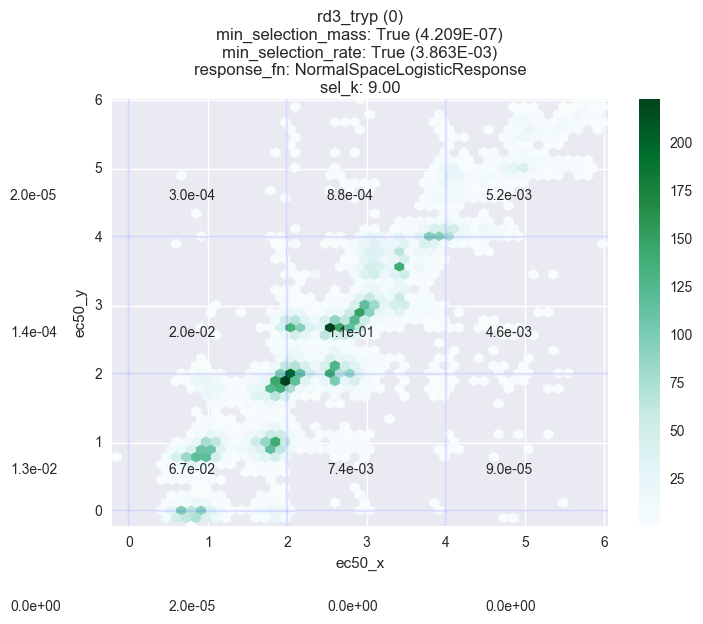

In [170]:
@ipyw.interact
def plot_single(idx=ipyw.IntSlider(min=min(eval_records.index.values), max=max(eval_records.index.values))):
    plot_eval_pair(pylab.gca(), idx)

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,sum_ms_log_d
7,rd3_tryp,0.0,0.000000,False,False,0.014498,0.016121,0.062463,0.084941,0.052167,0.122299,-0.467924,-0.087708,"((min_selection_rate, False), (response_fn, No...",0.847094,NormalSpaceLogisticResponse,8.999957,0.352488
4,rd3_tryp,0.0,0.004879,False,True,0.011146,0.013058,0.046673,0.065155,0.056744,0.441212,-0.313104,-0.041195,"((response_fn, LogisticResponse), (min_selecti...",0.896847,LogisticResponse,8.999529,0.633988


,dataset,neg_mse,neg_outlier_mse,pearsonr
0,rd3_tryp,-0.368697,-0.05483,0.892365


,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,sum_ms_log_d
13,rd2_chymo,6.275074e-07,0.000000,True,False,0.101428,0.132166,0.076982,0.431757,0.202272,0.370763,-1.973951,-0.694232,"((min_selection_rate, False), (min_selection_m...",0.614707,NormalSpaceLogisticResponse,0.576268,1.315368
12,rd2_chymo,0.000000e+00,0.039971,False,True,0.083715,0.107946,0.019745,0.427516,0.338617,0.453612,-1.561087,-0.565922,"((response_fn, LogisticResponse), (min_selecti...",0.529008,LogisticResponse,8.998927,1.431151


,dataset,neg_mse,neg_outlier_mse,pearsonr
1,rd2_chymo,-1.761397,-0.686568,0.583877


,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,sum_ms_log_d
20,rd2_tryp,0.000000,0.004084,False,True,0.033043,0.082975,0.065972,0.091922,0.014359,0.588031,-2.029797,-0.763092,"((response_fn, LogisticResponse), (min_selecti...",0.403037,LogisticResponse,8.999345,0.876302
22,rd2_tryp,0.000001,0.000000,True,False,0.031266,0.069643,0.063702,0.086612,0.031481,3.344543,-1.492558,-0.474356,"((min_selection_rate, False), (min_selection_m...",0.486105,LogisticResponse,8.998121,3.627246


,dataset,neg_mse,neg_outlier_mse,pearsonr
2,rd2_tryp,-1.704013,-0.570927,0.453168


,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,min_selection_rate,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,sum_ms_log_d
27,rd3_chymo,5.517879e-07,0.013045,True,True,0.016117,0.021731,0.028260,0.201006,0.248989,0.875767,-0.274765,-0.040268,"((min_selection_mass, True), (response_fn, Log...",0.888752,LogisticResponse,8.999453,1.391872
29,rd3_chymo,2.647036e-06,0.000000,True,False,0.016232,0.021609,0.031535,0.235521,0.308963,2.956686,-0.631560,-0.078454,"((min_selection_rate, False), (min_selection_m...",0.877917,NormalSpaceLogisticResponse,8.991147,3.570545


,dataset,neg_mse,neg_outlier_mse,pearsonr
3,rd3_chymo,-0.347277,-0.068745,0.89066


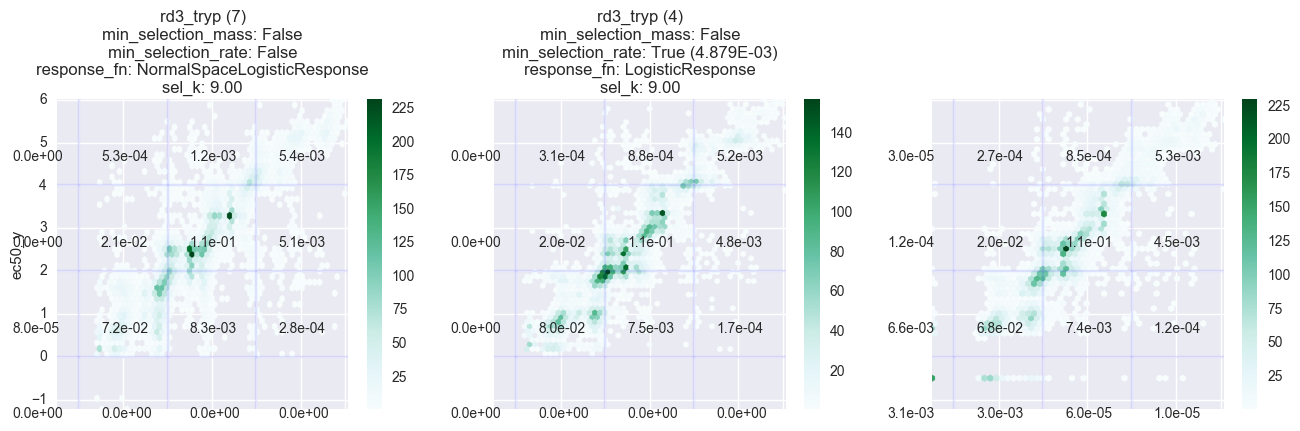

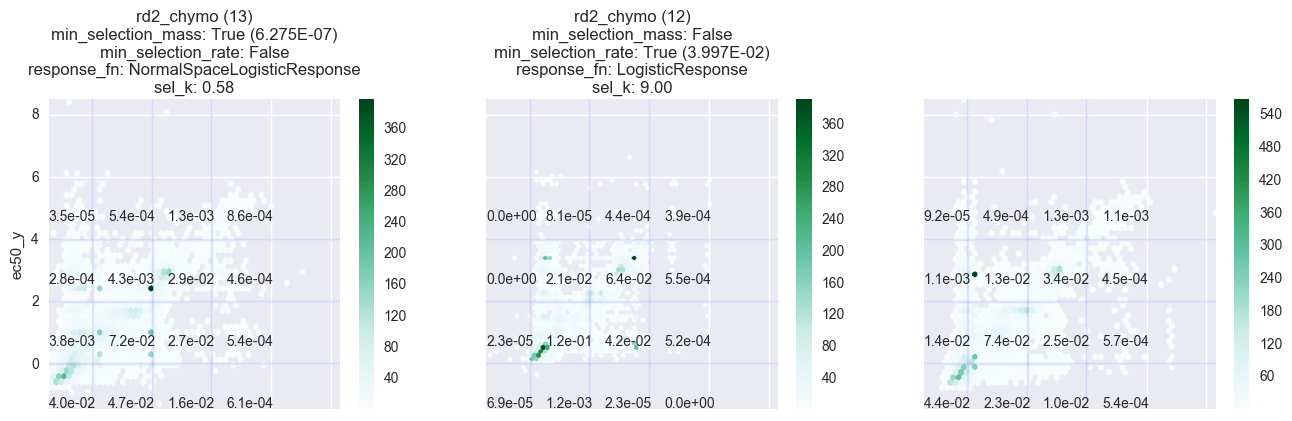

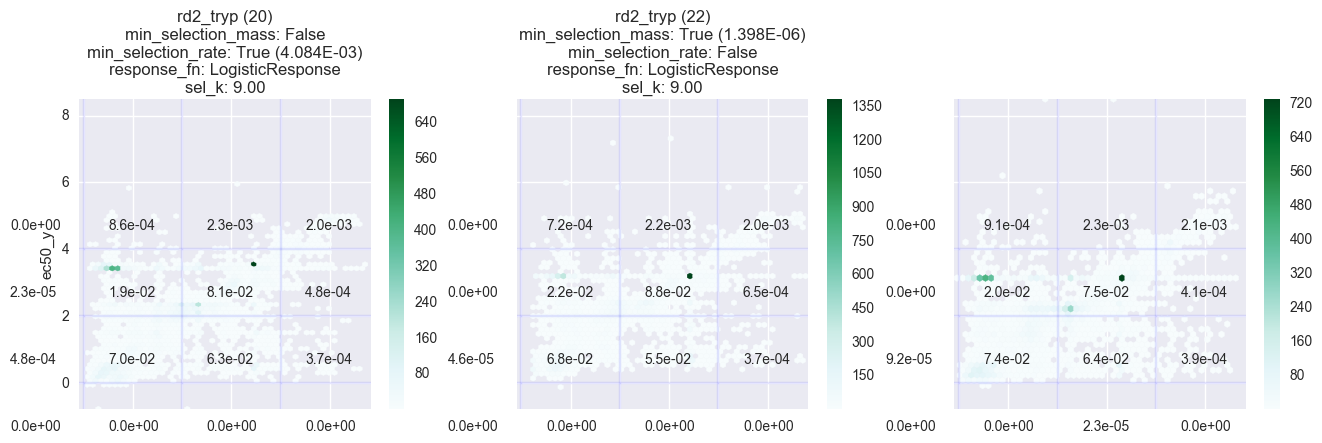

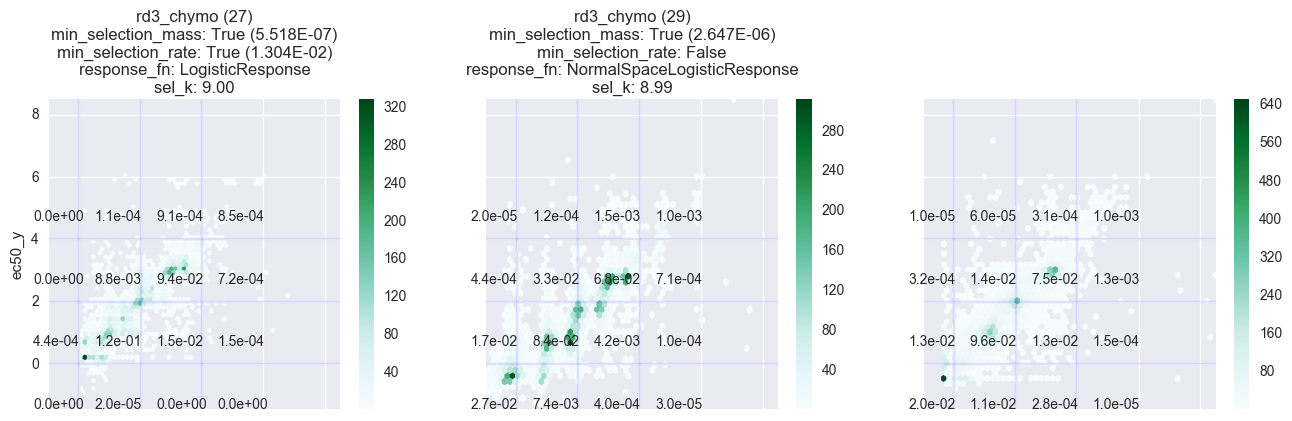

In [171]:
@ipyw.interact
def display_records(metric = list(model_evaluations) + ["sum_ms_log_d"]):
    
    for dataset in list(pandas.unique(eval_records["dataset"])):


        ss = eval_records[eval_records["dataset"] == dataset].sort_values(metric)
        b_i = ss.index[0]
        w_i = ss.index[-1]

        display(ss.iloc[[0, -1]])
        display(grockin_eval_records[grockin_eval_records["dataset"] == dataset])

        f, (a1, a2, a3) = pylab.subplots(ncols=3, sharex=True, sharey=True, figsize=(16, 4))
        plot_eval_pair(a1, b_i)
        plot_eval_pair(a2, w_i)
        
        pairplot_ec50(a3, grockin_fit_frames[dataset])
        
        #a3.set_title("%.3f\n%.3f\n%.3f" % (
        #        ss.iloc[0][metric],
        #        ss.iloc[-1][metric],
        #        grockin_eval_records.query("dataset == '%s'" % dataset).iloc[0][metric]
        #))